In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.eval_measures as smfem

In [2]:
# read in data

pop_data = pd.read_csv("..\data\covid_county_population_usafacts.csv")
confirmed_data = pd.read_csv("..\data\covid_confirmed_usafacts.csv")
death_data = pd.read_csv("..\data\covid_deaths_usafacts.csv")

In [3]:
# Washington Data: 

# Population by county
WA_pop_data = pop_data[pop_data['State'] == "WA"]

# State population
WA_pop_data_sum=WA_pop_data.population.sum()

# Confirmed case and death data 
WA_confirmed_data = confirmed_data[confirmed_data["State"] == "WA"]
WA_confirmed_data.drop(['countyFIPS', 'County Name', 'State', 'stateFIPS'], axis=1, inplace=True)

WA_death_data = death_data[death_data["State"] == "WA"]
WA_death_data.drop(['countyFIPS', 'County Name', 'State', 'stateFIPS'], axis=1, inplace=True)

# Rearrange data into a useful form
WA_confirmed_daily = pd.DataFrame(WA_confirmed_data[WA_confirmed_data.columns[0:]].sum()).reset_index()
WA_confirmed_daily.columns=["Date", "Confirmed Cases"]
WA_confirmed_daily["Date"] = pd.to_datetime(WA_confirmed_daily["Date"])
WA_confirmed_daily["Week"] = WA_confirmed_daily["Date"].dt.week

WA_death_daily = pd.DataFrame(WA_death_data[WA_death_data.columns[0:]].sum()).reset_index()
WA_death_daily.columns=["Date", "Deaths"]
WA_death_daily["Date"] = pd.to_datetime(WA_death_daily["Date"])
WA_death_daily["Week"] = WA_death_daily["Date"].dt.week

print(WA_confirmed_daily)
print(WA_death_daily)

          Date  Confirmed Cases  Week
0   2020-01-22                1     4
1   2020-01-23                1     4
2   2020-01-24                1     4
3   2020-01-25                1     4
4   2020-01-26                1     4
..         ...              ...   ...
292 2020-11-09           118570    46
293 2020-11-10           120011    46
294 2020-11-11           120011    46
295 2020-11-12           123356    46
296 2020-11-13           125498    46

[297 rows x 3 columns]
          Date  Deaths  Week
0   2020-01-22       0     4
1   2020-01-23       0     4
2   2020-01-24       0     4
3   2020-01-25       0     4
4   2020-01-26       0     4
..         ...     ...   ...
292 2020-11-09    2459    46
293 2020-11-10    2482    46
294 2020-11-11    2482    46
295 2020-11-12    2513    46
296 2020-11-13    2519    46

[297 rows x 3 columns]


C:\Users\sandm\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [4]:
# Merge the confirmed cases data with the death data

WA_merged=WA_confirmed_daily.merge(WA_death_daily)
WA_merged=WA_merged[["Date", "Week", "Confirmed Cases", "Deaths"]]
WA_merged.head()

,Date,Week,Confirmed Cases,Deaths
0,2020-01-22,4,1,0
1,2020-01-23,4,1,0
2,2020-01-24,4,1,0
3,2020-01-25,4,1,0
4,2020-01-26,4,1,0


In [5]:
# Create Days_Since_First_Case column

WA_merged.reset_index(inplace=True)
WA_merged=WA_merged.rename(columns= {'index': 'Days_Since_First_Case'})
WA_merged.head()

,Days_Since_First_Case,Date,Week,Confirmed Cases,Deaths
0,0,2020-01-22,4,1,0
1,1,2020-01-23,4,1,0
2,2,2020-01-24,4,1,0
3,3,2020-01-25,4,1,0
4,4,2020-01-26,4,1,0


In [6]:
# Calculate New_Cases and New_Deaths

WA_merged["New_Cases"]=WA_merged["Confirmed Cases"].diff()
WA_merged["New_Deaths"]=WA_merged["Deaths"].diff()
WA_merged["New_Cases"].fillna(0.0, inplace=True)
WA_merged["New_Deaths"].fillna(0.0, inplace=True)
WA_merged

,Days_Since_First_Case,Date,Week,Confirmed Cases,Deaths,New_Cases,New_Deaths
0,0,2020-01-22,4,1,0,0.0,0.0
1,1,2020-01-23,4,1,0,0.0,0.0
2,2,2020-01-24,4,1,0,0.0,0.0
3,3,2020-01-25,4,1,0,0.0,0.0
4,4,2020-01-26,4,1,0,0.0,0.0
...,...,...,...,...,...,...,...
292,292,2020-11-09,46,118570,2459,1239.0,22.0
293,293,2020-11-10,46,120011,2482,1441.0,23.0
294,294,2020-11-11,46,120011,2482,0.0,0.0
295,295,2020-11-12,46,123356,2513,3345.0,31.0


### Task 1

#### Utilize Linear and Non-Linear (polynomial) regression models to compare trends for a single state and its counties. Start your data from the first day of infections. X-Axis, number of days since the first case, Y-Axis number of new cases and deaths. Calcluate error using RMSE.

#### Identify which counties are most at risk. Model for top 5 counties with cases within a state and observe their trends.

 ### Modeling for Washington

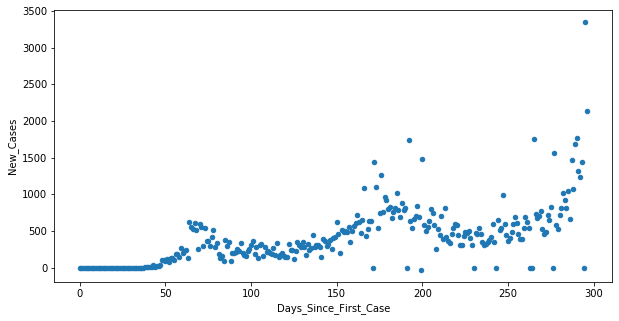

In [7]:
# Plot relationship of Days_Since_First_Case to New_Cases

WA_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Cases', figsize=(10, 5))


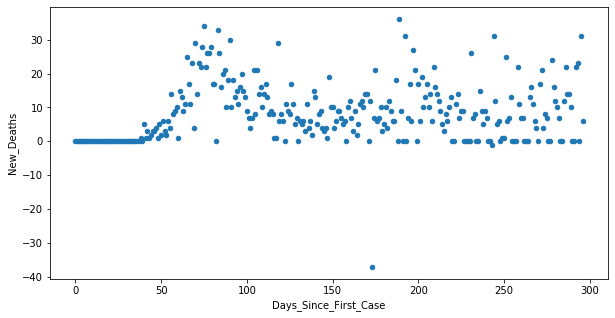

In [8]:
# Plot relationship of Days_Since_First_Case to New_Deaths

WA_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Deaths', figsize=(10, 5))

In [9]:
# Linear model for cases and deaths

linear_cases = smf.ols(formula='New_Cases ~ Days_Since_First_Case', data=WA_merged).fit()
linear_deaths = smf.ols(formula = 'New_Deaths ~ Days_Since_First_Case', data=WA_merged).fit()

In [10]:
# Predictions based on max and min values for Days_Since_First_Case

pred_cases_linear = linear_cases.predict(WA_merged["Days_Since_First_Case"])
pred_deaths_linear = linear_deaths.predict(WA_merged["Days_Since_First_Case"])

print(pred_cases_linear)
print(pred_deaths_linear)

0      -23.064086
1      -20.053188
2      -17.042290
3      -14.031392
4      -11.020494
          ...    
292    856.118137
293    859.129035
294    862.139933
295    865.150831
296    868.161729
Length: 297, dtype: float64
0       6.577814
1       6.590677
2       6.603539
3       6.616402
4       6.629264
         ...    
292    10.333699
293    10.346561
294    10.359424
295    10.372286
296    10.385149
Length: 297, dtype: float64


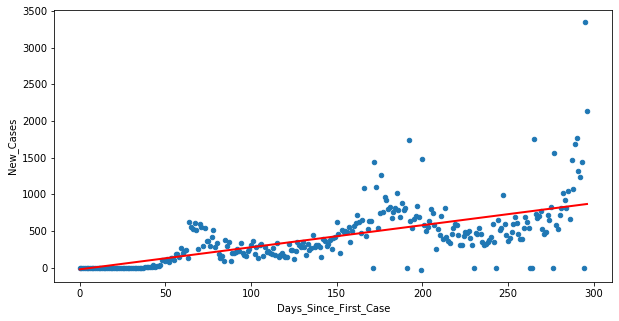

In [11]:
# Plot data and linear regression model for New_Cases

WA_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Cases', figsize=(10, 5))
plt.plot(WA_merged["Days_Since_First_Case"], pred_cases_linear, c='red', linewidth=2)

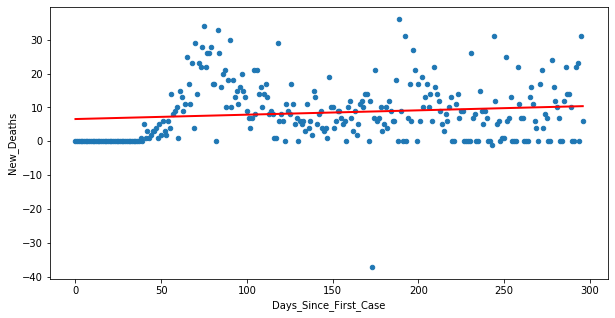

In [12]:
# Plot data and linear regression model for New_Deaths

WA_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Deaths', figsize=(10, 5))
plt.plot(WA_merged["Days_Since_First_Case"], pred_deaths_linear, c='red', linewidth=2)

In [13]:
print(linear_cases.summary())
print(linear_deaths.summary())

                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     201.9
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           2.89e-35
Time:                        21:10:03   Log-Likelihood:                -2127.1
No. Observations:                 297   AIC:                             4258.
Df Residuals:                     295   BIC:                             4266.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -23.06

In [14]:
# Calculate RMSE
RMSE_cases_linear=smfem.rmse(x1=WA_merged["New_Cases"], x2=pred_cases_linear)
RMSE_deaths_linear=smfem.rmse(x1=WA_merged["New_Deaths"], x2=pred_deaths_linear)
print("Linear Regression Model for New Cases RMSE: ", RMSE_cases_linear)
print("Linear Regression MOdel for New Deaths RMSE: ", RMSE_deaths_linear)

Linear Regression Model for New Cases RMSE:  312.04770774147676
Linear Regression MOdel for New Deaths RMSE:  8.589193930610767


In [15]:
# Non-linear fitted models for cases and deaths

nonlinear_cases = smf.ols(formula="New_Cases ~ 1 + Days_Since_First_Case + I(Days_Since_First_Case ** 2.0) + I(Days_Since_First_Case ** 3.0) + I(Days_Since_First_Case ** 4.0) + I(Days_Since_First_Case ** 5.0)", data=WA_merged).fit()
nonlinear_deaths = smf.ols(formula="New_Deaths ~ 1 + Days_Since_First_Case + I(Days_Since_First_Case ** 2.0) + I(Days_Since_First_Case ** 3.0) + I(Days_Since_First_Case ** 4.0) + I(Days_Since_First_Case ** 5.0)", data=WA_merged).fit()


In [16]:
# Predictions for Days_Since_First_Case

pred_cases_nonlinear = nonlinear_cases.predict(WA_merged["Days_Since_First_Case"])
pred_deaths_nonlinear = nonlinear_deaths.predict(WA_merged["Days_Since_First_Case"])

print(pred_cases_nonlinear)
print(pred_deaths_nonlinear)

0      -225.791160
1      -200.686134
2      -176.774714
3      -154.019895
4      -132.385307
          ...     
292    1450.912686
293    1509.142028
294    1569.656033
295    1632.509921
296    1697.759680
Length: 297, dtype: float64
0     -4.760618
1     -4.455657
2     -4.150151
3     -3.844266
4     -3.538171
         ...   
292    9.737710
293    9.665565
294    9.585551
295    9.497399
296    9.400834
Length: 297, dtype: float64


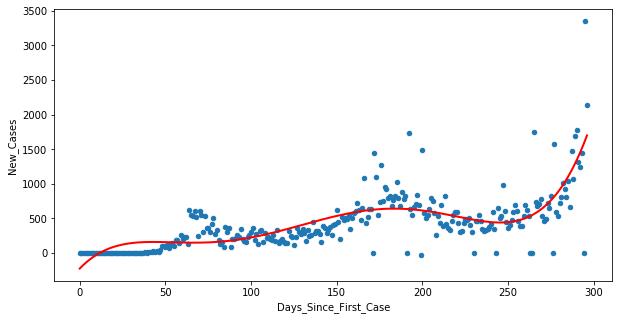

In [17]:
# Plot data and non-linear regression model for New_Cases

WA_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Cases', figsize=(10, 5))
plt.plot(WA_merged["Days_Since_First_Case"], pred_cases_nonlinear, c='red', linewidth=2)

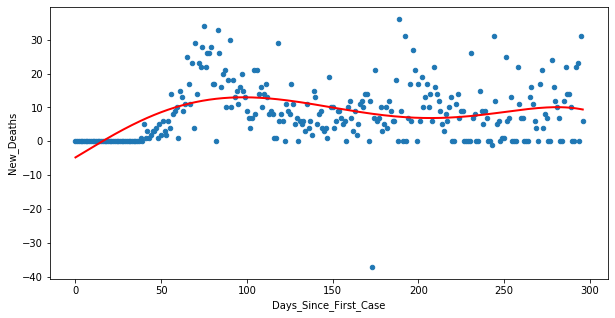

In [18]:
# Plot data and non-linear regression model for New_Deaths

WA_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Deaths', figsize=(10, 5))
plt.plot(WA_merged["Days_Since_First_Case"], pred_deaths_nonlinear, c='red', linewidth=2)

In [19]:
print(nonlinear_cases.summary())
print(nonlinear_deaths.summary())

                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     76.53
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           5.27e-51
Time:                        21:10:04   Log-Likelihood:                -2079.9
No. Observations:                 297   AIC:                             4172.
Df Residuals:                     291   BIC:                             4194.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [20]:
# Calculate RMSE

RMSE_cases_nonlinear=smfem.rmse(x1=WA_merged["New_Cases"], x2=pred_cases_nonlinear)
RMSE_deaths_nonlinear=smfem.rmse(x1=WA_merged["New_Deaths"], x2=pred_deaths_nonlinear)
print("Non-Linear Regression Model for New Cases RMSE: ", RMSE_cases_nonlinear)
print("Non-Linear Regression Model for New Deaths RMSE: ", RMSE_deaths_nonlinear)

Non-Linear Regression Model for New Cases RMSE:  266.17766900328564
Non-Linear Regression Model for New Deaths RMSE:  7.829011488762823


#### A lower RMSE for the non-linear regression models indicates a better fit than the linear regression model

### Modeling for Washington Counties

In [21]:
WA_confirmed_data=confirmed_data[confirmed_data['State']== 'WA']
WA_confirmed_data.drop(['countyFIPS', 'State', 'stateFIPS'], axis=1, inplace=True)
WA_death_data=death_data[death_data['State'] == 'WA']
WA_death_data.drop(['countyFIPS', 'State', 'stateFIPS'], axis=1, inplace=True)

In [22]:
# Find top five at risk counties (highest infection per 10000)

county_confirmed_total=WA_confirmed_data.filter(['County Name', '11/13/20'])
county_confirmed_total.rename(columns={'11/13/20': 'Total Cases'}, inplace=True)

# Merge with population data and sort by Total Cases
county_pop_confirmed = pd.merge(WA_pop_data, county_confirmed_total)
county_pop_confirmed = county_pop_confirmed[county_pop_confirmed['population'] != 0].dropna()
county_pop_confirmed.drop(['countyFIPS', 'State'], axis = 1, inplace = True)
county_pop_confirmed.sort_values('Total Cases', ascending=False).set_index('County Name')
county_pop_confirmed['Cases per 10000'] = (county_pop_confirmed['Total Cases']/county_pop_confirmed['population'] * 10000).round()
county_pop_confirmed.sort_values('Cases per 10000', ascending=False).head(5)

,County Name,population,Total Cases,Cases per 10000
11,Franklin County,95222,5317,558.0
1,Adams County,19983,1075,538.0
39,Yakima County,250873,12354,492.0
38,Whitman County,50104,1956,390.0
13,Grant County,97733,3604,369.0


#### Franklin County

In [23]:
Franklin_pop_data=WA_pop_data[WA_pop_data['County Name'] == 'Franklin County']
Franklin_pop=Franklin_pop_data['population'].sum()

Franklin_confirmed_data=WA_confirmed_data[WA_confirmed_data['County Name']=='Franklin County']
Franklin_confirmed_data.drop(['County Name'], axis=1, inplace=True)
Franklin_confirmed_daily = pd.DataFrame(Franklin_confirmed_data[Franklin_confirmed_data.columns[0:]].sum()).reset_index()
Franklin_confirmed_daily.columns=["Date", "Confirmed Cases"]
Franklin_confirmed_daily["Date"] = pd.to_datetime(Franklin_confirmed_daily["Date"])
Franklin_confirmed_daily["Week"] = Franklin_confirmed_daily["Date"].dt.week



Franklin_death_data=WA_death_data[WA_death_data['County Name']=='Franklin County']
Franklin_death_data.drop(['County Name'], axis=1, inplace=True)
Franklin_death_daily = pd.DataFrame(Franklin_death_data[Franklin_death_data.columns[0:]].sum()).reset_index()
Franklin_death_daily.columns=["Date", "Deaths"]
Franklin_death_daily["Date"] = pd.to_datetime(Franklin_death_daily["Date"])
Franklin_death_daily["Week"] = Franklin_death_daily["Date"].dt.week


Franklin_merged=Franklin_confirmed_daily.merge(Franklin_death_daily)
Franklin_merged=Franklin_merged[["Date", "Week", "Confirmed Cases", "Deaths"]]
Franklin_merged.head()

# Create Days_Since_First_Case column

Franklin_merged.reset_index(inplace=True)
Franklin_merged=Franklin_merged.rename(columns= {'index': 'Days_Since_First_Case'})
Franklin_merged.head()

# Calculate New_Cases and New_Deaths

Franklin_merged["New_Cases"]=Franklin_merged["Confirmed Cases"].diff()
Franklin_merged["New_Deaths"]=Franklin_merged["Deaths"].diff()
Franklin_merged["New_Cases"].fillna(0.0, inplace=True)
Franklin_merged["New_Deaths"].fillna(0.0, inplace=True)
Franklin_merged

,Days_Since_First_Case,Date,Week,Confirmed Cases,Deaths,New_Cases,New_Deaths
0,0,2020-01-22,4,0,0,0.0,0.0
1,1,2020-01-23,4,0,0,0.0,0.0
2,2,2020-01-24,4,0,0,0.0,0.0
3,3,2020-01-25,4,0,0,0.0,0.0
4,4,2020-01-26,4,0,0,0.0,0.0
...,...,...,...,...,...,...,...
292,292,2020-11-09,46,5171,69,29.0,0.0
293,293,2020-11-10,46,5221,69,50.0,0.0
294,294,2020-11-11,46,5221,69,0.0,0.0
295,295,2020-11-12,46,5301,69,80.0,0.0


0       3.223352
1       3.322535
2       3.421717
3       3.520899
4       3.620082
         ...    
292    32.184632
293    32.283814
294    32.382997
295    32.482179
296    32.581362
Length: 297, dtype: float64
0      0.149075
1      0.149637
2      0.150200
3      0.150762
4      0.151325
         ...   
292    0.313322
293    0.313884
294    0.314447
295    0.315009
296    0.315572
Length: 297, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     56.06
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           8.17e-13
Time:                        21:10:05   Log-Likelihood:                -1303.7
No. Observations:                 297   AIC:                             2611.
Df Residuals:               

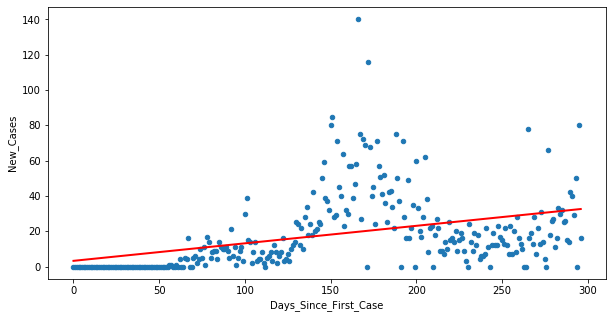

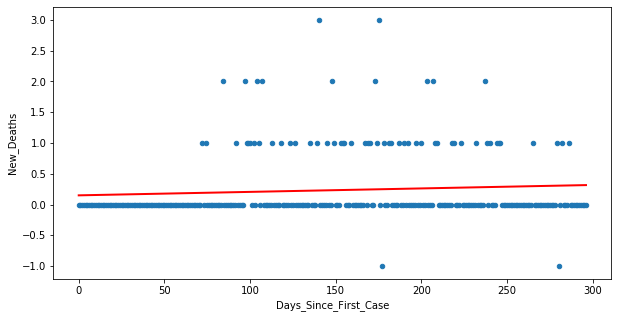

In [24]:
# Linear model for cases and deaths

linear_cases = smf.ols(formula='New_Cases ~ Days_Since_First_Case', data=Franklin_merged).fit()
linear_deaths = smf.ols(formula = 'New_Deaths ~ Days_Since_First_Case', data=Franklin_merged).fit()

# Predictions based on max and min values for Days_Since_First_Case

pred_cases_linear = linear_cases.predict(Franklin_merged["Days_Since_First_Case"])
pred_deaths_linear = linear_deaths.predict(Franklin_merged["Days_Since_First_Case"])

print(pred_cases_linear)
print(pred_deaths_linear)

# Plot data and linear regression model for New_Cases

Franklin_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Cases', figsize=(10, 5))
plt.plot(Franklin_merged["Days_Since_First_Case"], pred_cases_linear, c='red', linewidth=2)

# Plot data and linear regression model for New_Deaths

Franklin_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Deaths', figsize=(10, 5))
plt.plot(Franklin_merged["Days_Since_First_Case"], pred_deaths_linear, c='red', linewidth=2)

print(linear_cases.summary())
print(linear_deaths.summary())

# Calculate RMSE
RMSE_cases_linear=smfem.rmse(x1=Franklin_merged["New_Cases"], x2=pred_cases_linear)
RMSE_deaths_linear=smfem.rmse(x1=Franklin_merged["New_Deaths"], x2=pred_deaths_linear)
print("Linear Regression Model for New Cases RMSE: ", RMSE_cases_linear)
print("Linear Regression MOdel for New Deaths RMSE: ", RMSE_deaths_linear)


0      -0.948282
1      -0.651894
2      -0.383560
3      -0.141981
4       0.074113
         ...    
292    40.135560
293    42.491200
294    44.957767
295    47.537993
296    50.234646
Length: 297, dtype: float64
0      0.041032
1      0.033823
2      0.027041
3      0.020678
4      0.014724
         ...   
292    0.035035
293    0.031124
294    0.027197
295    0.023254
296    0.019294
Length: 297, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     50.88
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           8.69e-38
Time:                        22:08:28   Log-Likelihood:                -1236.3
No. Observations:                 297   AIC:                             2485.
Df Residuals:               

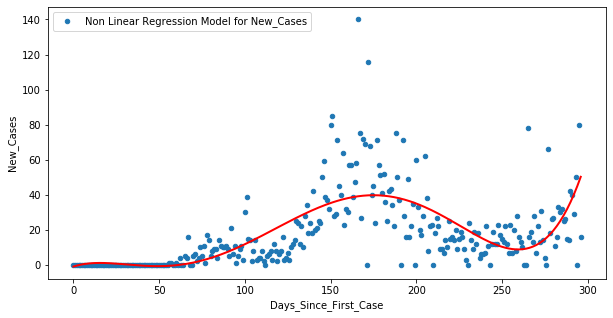

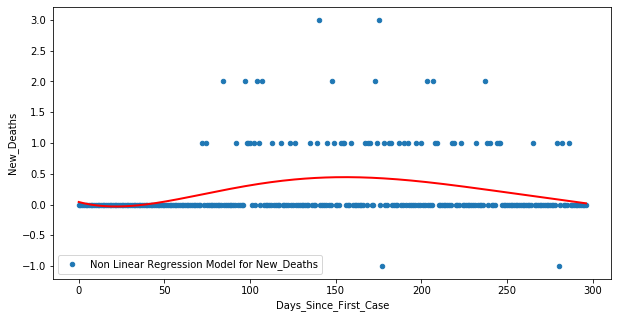

In [83]:
# Non-linear fitted models for cases and deaths

nonlinear_cases = smf.ols(formula="New_Cases ~ 1 + Days_Since_First_Case + I(Days_Since_First_Case ** 2.0) + I(Days_Since_First_Case ** 3.0) + I(Days_Since_First_Case ** 4.0) + I(Days_Since_First_Case ** 5.0)", data=Franklin_merged).fit()
nonlinear_deaths = smf.ols(formula="New_Deaths ~ 1 + Days_Since_First_Case + I(Days_Since_First_Case ** 2.0) + I(Days_Since_First_Case ** 3.0) + I(Days_Since_First_Case ** 4.0) + I(Days_Since_First_Case ** 5.0)", data=Franklin_merged).fit()


# Predictions for Days_Since_First_Case

pred_cases_nonlinear = nonlinear_cases.predict(Franklin_merged["Days_Since_First_Case"])
pred_deaths_nonlinear = nonlinear_deaths.predict(Franklin_merged["Days_Since_First_Case"])

print(pred_cases_nonlinear)
print(pred_deaths_nonlinear)

# Plot data and non-linear regression model for New_Cases

Franklin_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Cases', label="Non Linear Regression Model for New_Cases", figsize=(10, 5))
plt.plot(Franklin_merged["Days_Since_First_Case"], pred_cases_nonlinear, c='red', linewidth=2)

# Plot data and non-linear regression model for New_Deaths

Franklin_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Deaths', label="Non Linear Regression Model for New_Deaths", figsize=(10, 5))
plt.plot(Franklin_merged["Days_Since_First_Case"], pred_deaths_nonlinear, c='red', linewidth=2)

print(nonlinear_cases.summary())
print(nonlinear_deaths.summary())

# Calculate RMSE

RMSE_cases_nonlinear=smfem.rmse(x1=Franklin_merged["New_Cases"], x2=pred_cases_nonlinear)
RMSE_deaths_nonlinear=smfem.rmse(x1=Franklin_merged["New_Deaths"], x2=pred_deaths_nonlinear)
print("Non-Linear Regression Model for New Cases RMSE: ", RMSE_cases_nonlinear)
print("Non-Linear Regression Model for New Deaths RMSE: ", RMSE_deaths_nonlinear)

#### Adams County

In [26]:
Adams_pop_data=WA_pop_data[WA_pop_data['County Name'] == 'Adams County']
Adams_pop=Adams_pop_data['population'].sum()

Adams_confirmed_data=WA_confirmed_data[WA_confirmed_data['County Name']=='Adams County']
Adams_confirmed_data.drop(['County Name'], axis=1, inplace=True)
Adams_confirmed_daily = pd.DataFrame(Adams_confirmed_data[Adams_confirmed_data.columns[0:]].sum()).reset_index()
Adams_confirmed_daily.columns=["Date", "Confirmed Cases"]
Adams_confirmed_daily["Date"] = pd.to_datetime(Adams_confirmed_daily["Date"])
Adams_confirmed_daily["Week"] = Adams_confirmed_daily["Date"].dt.week



Adams_death_data=WA_death_data[WA_death_data['County Name']=='Adams County']
Adams_death_data.drop(['County Name'], axis=1, inplace=True)
Adams_death_daily = pd.DataFrame(Adams_death_data[Adams_death_data.columns[0:]].sum()).reset_index()
Adams_death_daily.columns=["Date", "Deaths"]
Adams_death_daily["Date"] = pd.to_datetime(Adams_death_daily["Date"])
Adams_death_daily["Week"] = Adams_death_daily["Date"].dt.week


Adams_merged=Adams_confirmed_daily.merge(Adams_death_daily)
Adams_merged=Adams_merged[["Date", "Week", "Confirmed Cases", "Deaths"]]
Adams_merged.head()

# Create Days_Since_First_Case column

Adams_merged.reset_index(inplace=True)
Adams_merged=Adams_merged.rename(columns= {'index': 'Days_Since_First_Case'})
Adams_merged.head()

# Calculate New_Cases and New_Deaths

Adams_merged["New_Cases"]=Adams_merged["Confirmed Cases"].diff()
Adams_merged["New_Deaths"]=Adams_merged["Deaths"].diff()
Adams_merged["New_Cases"].fillna(0.0, inplace=True)
Adams_merged["New_Deaths"].fillna(0.0, inplace=True)
Adams_merged

,Days_Since_First_Case,Date,Week,Confirmed Cases,Deaths,New_Cases,New_Deaths
0,0,2020-01-22,4,0,0,0.0,0.0
1,1,2020-01-23,4,0,0,0.0,0.0
2,2,2020-01-24,4,0,0,0.0,0.0
3,3,2020-01-25,4,0,0,0.0,0.0
4,4,2020-01-26,4,0,0,0.0,0.0
...,...,...,...,...,...,...,...
292,292,2020-11-09,46,991,11,2.0,0.0
293,293,2020-11-10,46,993,11,2.0,0.0
294,294,2020-11-11,46,993,11,0.0,0.0
295,295,2020-11-12,46,1030,11,37.0,0.0


0     -0.942535
1     -0.911710
2     -0.880885
3     -0.850061
4     -0.819236
         ...   
292    8.058293
293    8.089118
294    8.119943
295    8.150767
296    8.181592
Length: 297, dtype: float64
0     -0.012655
1     -0.012319
2     -0.011983
3     -0.011647
4     -0.011311
         ...   
292    0.085386
293    0.085721
294    0.086057
295    0.086393
296    0.086729
Length: 297, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     64.20
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           2.63e-14
Time:                        21:10:07   Log-Likelihood:                -936.52
No. Observations:                 297   AIC:                             1877.
Df Residuals:                     295  

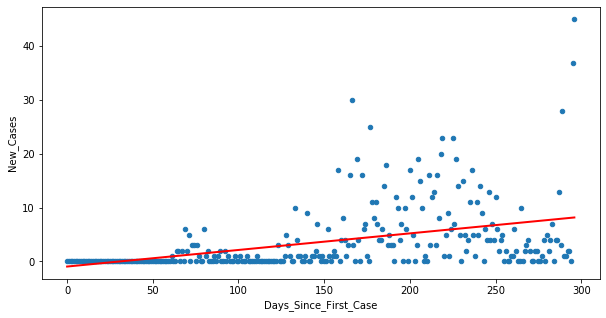

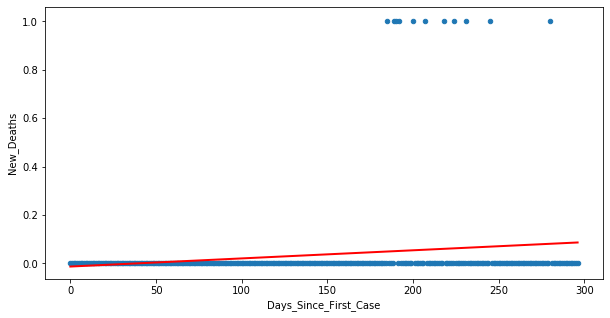

In [27]:
# Linear model for cases and deaths

linear_cases = smf.ols(formula='New_Cases ~ Days_Since_First_Case', data=Adams_merged).fit()
linear_deaths = smf.ols(formula = 'New_Deaths ~ Days_Since_First_Case', data=Adams_merged).fit()

# Predictions based on max and min values for Days_Since_First_Case

pred_cases_linear = linear_cases.predict(Adams_merged["Days_Since_First_Case"])
pred_deaths_linear = linear_deaths.predict(Adams_merged["Days_Since_First_Case"])

print(pred_cases_linear)
print(pred_deaths_linear)

# Plot data and linear regression model for New_Cases

Adams_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Cases', figsize=(10, 5))
plt.plot(Adams_merged["Days_Since_First_Case"], pred_cases_linear, c='red', linewidth=2)

# Plot data and linear regression model for New_Deaths

Adams_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Deaths', figsize=(10, 5))
plt.plot(Adams_merged["Days_Since_First_Case"], pred_deaths_linear, c='red', linewidth=2)

print(linear_cases.summary())
print(linear_deaths.summary())

# Calculate RMSE
RMSE_cases_linear=smfem.rmse(x1=Adams_merged["New_Cases"], x2=pred_cases_linear)
RMSE_deaths_linear=smfem.rmse(x1=Adams_merged["New_Deaths"], x2=pred_deaths_linear)
print("Linear Regression Model for New Cases RMSE: ", RMSE_cases_linear)
print("Linear Regression MOdel for New Deaths RMSE: ", RMSE_deaths_linear)


0      -3.595841
1      -3.167785
2      -2.762593
3      -2.379575
4      -2.018054
         ...    
292    10.121510
293    10.646527
294    11.199177
295    11.780240
296    12.390509
Length: 297, dtype: float64
0     -0.047175
1     -0.041535
2     -0.036195
3     -0.031144
4     -0.026376
         ...   
292    0.013349
293    0.013906
294    0.014635
295    0.015543
296    0.016636
Length: 297, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     24.37
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           1.74e-20
Time:                        21:10:07   Log-Likelihood:                -913.82
No. Observations:                 297   AIC:                             1840.
Df Residuals:               

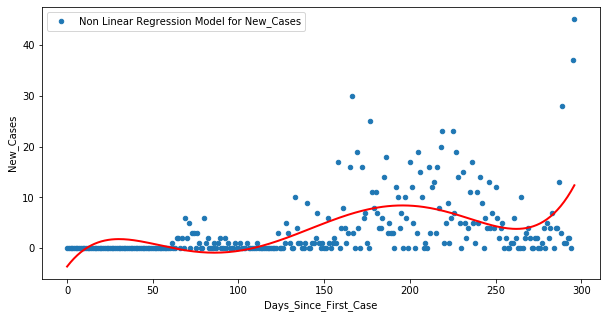

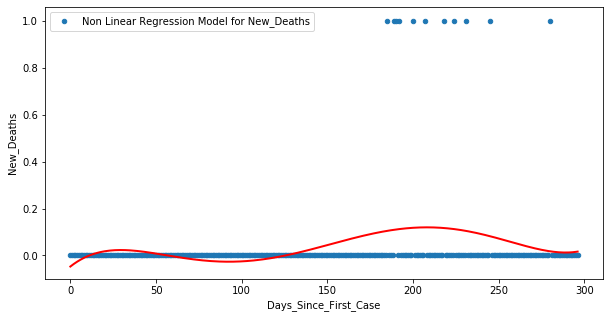

In [28]:
# Non-linear fitted models for cases and deaths

nonlinear_cases = smf.ols(formula="New_Cases ~ 1 + Days_Since_First_Case + I(Days_Since_First_Case ** 2.0) + I(Days_Since_First_Case ** 3.0) + I(Days_Since_First_Case ** 4.0) + I(Days_Since_First_Case ** 5.0)", data=Adams_merged).fit()
nonlinear_deaths = smf.ols(formula="New_Deaths ~ 1 + Days_Since_First_Case + I(Days_Since_First_Case ** 2.0) + I(Days_Since_First_Case ** 3.0) + I(Days_Since_First_Case ** 4.0) + I(Days_Since_First_Case ** 5.0)", data=Adams_merged).fit()


# Predictions for Days_Since_First_Case

pred_cases_nonlinear = nonlinear_cases.predict(Adams_merged["Days_Since_First_Case"])
pred_deaths_nonlinear = nonlinear_deaths.predict(Adams_merged["Days_Since_First_Case"])

print(pred_cases_nonlinear)
print(pred_deaths_nonlinear)

# Plot data and non-linear regression model for New_Cases

Adams_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Cases', label="Non Linear Regression Model for New_Cases", figsize=(10, 5))
plt.plot(Adams_merged["Days_Since_First_Case"], pred_cases_nonlinear, c='red', linewidth=2)

# Plot data and non-linear regression model for New_Deaths

Adams_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Deaths', label="Non Linear Regression Model for New_Deaths", figsize=(10, 5))
plt.plot(Adams_merged["Days_Since_First_Case"], pred_deaths_nonlinear, c='red', linewidth=2)

print(nonlinear_cases.summary())
print(nonlinear_deaths.summary())

# Calculate RMSE

RMSE_cases_nonlinear=smfem.rmse(x1=Adams_merged["New_Cases"], x2=pred_cases_nonlinear)
RMSE_deaths_nonlinear=smfem.rmse(x1=Adams_merged["New_Deaths"], x2=pred_deaths_nonlinear)
print("Non-Linear Regression Model for New Cases RMSE: ", RMSE_cases_nonlinear)
print("Non-Linear Regression Model for New Deaths RMSE: ", RMSE_deaths_nonlinear)

#### Yakima County

In [29]:
Yakima_pop_data=WA_pop_data[WA_pop_data['County Name'] == 'Yakima County']
Yakima_pop=Yakima_pop_data['population'].sum()

Yakima_confirmed_data=WA_confirmed_data[WA_confirmed_data['County Name']=='Yakima County']
Yakima_confirmed_data.drop(['County Name'], axis=1, inplace=True)
Yakima_confirmed_daily = pd.DataFrame(Yakima_confirmed_data[Yakima_confirmed_data.columns[0:]].sum()).reset_index()
Yakima_confirmed_daily.columns=["Date", "Confirmed Cases"]
Yakima_confirmed_daily["Date"] = pd.to_datetime(Yakima_confirmed_daily["Date"])
Yakima_confirmed_daily["Week"] = Yakima_confirmed_daily["Date"].dt.week



Yakima_death_data=WA_death_data[WA_death_data['County Name']=='Yakima County']
Yakima_death_data.drop(['County Name'], axis=1, inplace=True)
Yakima_death_daily = pd.DataFrame(Yakima_death_data[Yakima_death_data.columns[0:]].sum()).reset_index()
Yakima_death_daily.columns=["Date", "Deaths"]
Yakima_death_daily["Date"] = pd.to_datetime(Yakima_death_daily["Date"])
Yakima_death_daily["Week"] = Yakima_death_daily["Date"].dt.week


Yakima_merged=Yakima_confirmed_daily.merge(Yakima_death_daily)
Yakima_merged=Yakima_merged[["Date", "Week", "Confirmed Cases", "Deaths"]]
Yakima_merged.head()

# Create Days_Since_First_Case column

Yakima_merged.reset_index(inplace=True)
Yakima_merged=Yakima_merged.rename(columns= {'index': 'Days_Since_First_Case'})
Yakima_merged.head()

# Calculate New_Cases and New_Deaths

Yakima_merged["New_Cases"]=Yakima_merged["Confirmed Cases"].diff()
Yakima_merged["New_Deaths"]=Yakima_merged["Deaths"].diff()
Yakima_merged["New_Cases"].fillna(0.0, inplace=True)
Yakima_merged["New_Deaths"].fillna(0.0, inplace=True)
Yakima_merged

,Days_Since_First_Case,Date,Week,Confirmed Cases,Deaths,New_Cases,New_Deaths
0,0,2020-01-22,4,0,0,0.0,0.0
1,1,2020-01-23,4,0,0,0.0,0.0
2,2,2020-01-24,4,0,0,0.0,0.0
3,3,2020-01-25,4,0,0,0.0,0.0
4,4,2020-01-26,4,0,0,0.0,0.0
...,...,...,...,...,...,...,...
292,292,2020-11-09,46,12214,281,11.0,1.0
293,293,2020-11-10,46,12270,284,56.0,3.0
294,294,2020-11-11,46,12270,284,0.0,0.0
295,295,2020-11-12,46,12303,281,33.0,-3.0


0      32.397126
1      32.459280
2      32.521434
3      32.583588
4      32.645743
         ...    
292    50.546176
293    50.608331
294    50.670485
295    50.732639
296    50.794794
Length: 297, dtype: float64
0      0.730233
1      0.731737
2      0.733241
3      0.734746
4      0.736250
         ...   
292    1.169474
293    1.170978
294    1.172482
295    1.173987
296    1.175491
Length: 297, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.425
Date:                Sun, 15 Nov 2020   Prob (F-statistic):             0.0652
Time:                        21:10:08   Log-Likelihood:                -1580.0
No. Observations:                 297   AIC:                             3164.
Df Residuals:               

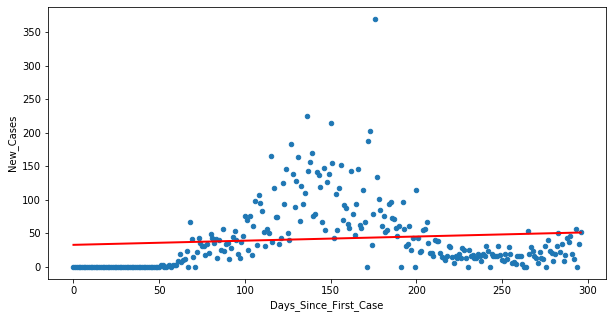

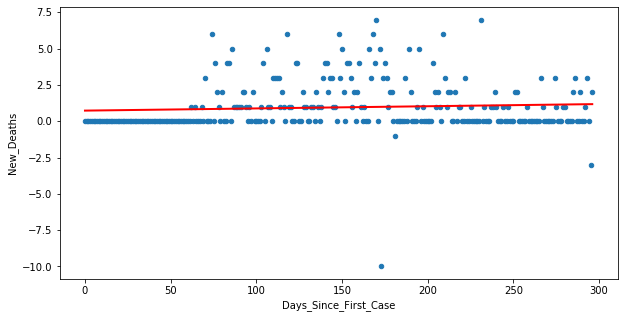

In [30]:
# Linear model for cases and deaths

linear_cases = smf.ols(formula='New_Cases ~ Days_Since_First_Case', data=Yakima_merged).fit()
linear_deaths = smf.ols(formula = 'New_Deaths ~ Days_Since_First_Case', data=Yakima_merged).fit()

# Predictions based on max and min values for Days_Since_First_Case

pred_cases_linear = linear_cases.predict(Yakima_merged["Days_Since_First_Case"])
pred_deaths_linear = linear_deaths.predict(Yakima_merged["Days_Since_First_Case"])

print(pred_cases_linear)
print(pred_deaths_linear)

# Plot data and linear regression model for New_Cases

Yakima_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Cases', figsize=(10, 5))
plt.plot(Yakima_merged["Days_Since_First_Case"], pred_cases_linear, c='red', linewidth=2)

# Plot data and linear regression model for New_Deaths

Yakima_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Deaths', figsize=(10, 5))
plt.plot(Yakima_merged["Days_Since_First_Case"], pred_deaths_linear, c='red', linewidth=2)

print(linear_cases.summary())
print(linear_deaths.summary())

# Calculate RMSE
RMSE_cases_linear=smfem.rmse(x1=Yakima_merged["New_Cases"], x2=pred_cases_linear)
RMSE_deaths_linear=smfem.rmse(x1=Yakima_merged["New_Deaths"], x2=pred_deaths_linear)
print("Linear Regression Model for New Cases RMSE: ", RMSE_cases_linear)
print("Linear Regression MOdel for New Deaths RMSE: ", RMSE_deaths_linear)


0      24.002176
1      21.271003
2      18.663402
3      16.177140
4      13.810006
         ...    
292    44.371687
293    47.284772
294    50.316357
295    53.468390
296    56.742830
Length: 297, dtype: float64
0      0.208626
1      0.173252
2      0.140056
3      0.108990
4      0.080005
         ...   
292    0.668610
293    0.685748
294    0.703581
295    0.722112
296    0.741342
Length: 297, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     75.23
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           2.14e-50
Time:                        21:10:09   Log-Likelihood:                -1458.5
No. Observations:                 297   AIC:                             2929.
Df Residuals:               

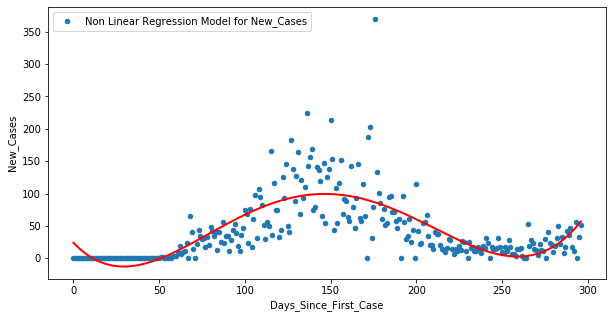

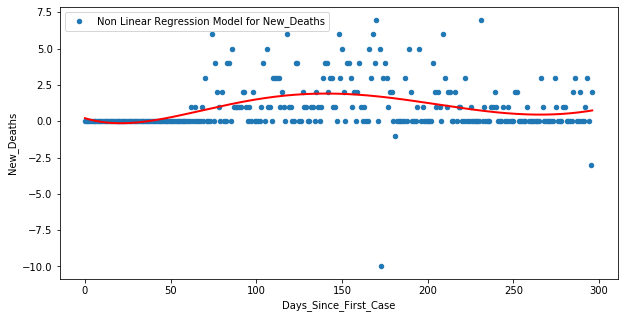

In [31]:
# Non-linear fitted models for cases and deaths

nonlinear_cases = smf.ols(formula="New_Cases ~ 1 + Days_Since_First_Case + I(Days_Since_First_Case ** 2.0) + I(Days_Since_First_Case ** 3.0) + I(Days_Since_First_Case ** 4.0) + I(Days_Since_First_Case ** 5.0)", data=Yakima_merged).fit()
nonlinear_deaths = smf.ols(formula="New_Deaths ~ 1 + Days_Since_First_Case + I(Days_Since_First_Case ** 2.0) + I(Days_Since_First_Case ** 3.0) + I(Days_Since_First_Case ** 4.0) + I(Days_Since_First_Case ** 5.0)", data=Yakima_merged).fit()


# Predictions for Days_Since_First_Case

pred_cases_nonlinear = nonlinear_cases.predict(Yakima_merged["Days_Since_First_Case"])
pred_deaths_nonlinear = nonlinear_deaths.predict(Yakima_merged["Days_Since_First_Case"])

print(pred_cases_nonlinear)
print(pred_deaths_nonlinear)

# Plot data and non-linear regression model for New_Cases

Yakima_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Cases', label="Non Linear Regression Model for New_Cases", figsize=(10, 5))
plt.plot(Yakima_merged["Days_Since_First_Case"], pred_cases_nonlinear, c='red', linewidth=2)

# Plot data and non-linear regression model for New_Deaths

Yakima_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Deaths', label="Non Linear Regression Model for New_Deaths", figsize=(10, 5))
plt.plot(Yakima_merged["Days_Since_First_Case"], pred_deaths_nonlinear, c='red', linewidth=2)

print(nonlinear_cases.summary())
print(nonlinear_deaths.summary())

# Calculate RMSE

RMSE_cases_nonlinear=smfem.rmse(x1=Yakima_merged["New_Cases"], x2=pred_cases_nonlinear)
RMSE_deaths_nonlinear=smfem.rmse(x1=Yakima_merged["New_Deaths"], x2=pred_deaths_nonlinear)
print("Non-Linear Regression Model for New Cases RMSE: ", RMSE_cases_nonlinear)
print("Non-Linear Regression Model for New Deaths RMSE: ", RMSE_deaths_nonlinear)

#### Whitman County

In [32]:
Whitman_pop_data=WA_pop_data[WA_pop_data['County Name'] == 'Whitman County']
Whitman_pop=Whitman_pop_data['population'].sum()

Whitman_confirmed_data=WA_confirmed_data[WA_confirmed_data['County Name']=='Whitman County']
Whitman_confirmed_data.drop(['County Name'], axis=1, inplace=True)
Whitman_confirmed_daily = pd.DataFrame(Whitman_confirmed_data[Whitman_confirmed_data.columns[0:]].sum()).reset_index()
Whitman_confirmed_daily.columns=["Date", "Confirmed Cases"]
Whitman_confirmed_daily["Date"] = pd.to_datetime(Whitman_confirmed_daily["Date"])
Whitman_confirmed_daily["Week"] = Whitman_confirmed_daily["Date"].dt.week



Whitman_death_data=WA_death_data[WA_death_data['County Name']=='Whitman County']
Whitman_death_data.drop(['County Name'], axis=1, inplace=True)
Whitman_death_daily = pd.DataFrame(Whitman_death_data[Whitman_death_data.columns[0:]].sum()).reset_index()
Whitman_death_daily.columns=["Date", "Deaths"]
Whitman_death_daily["Date"] = pd.to_datetime(Whitman_death_daily["Date"])
Whitman_death_daily["Week"] = Whitman_death_daily["Date"].dt.week


Whitman_merged=Whitman_confirmed_daily.merge(Whitman_death_daily)
Whitman_merged=Whitman_merged[["Date", "Week", "Confirmed Cases", "Deaths"]]
Whitman_merged.head()

# Create Days_Since_First_Case column

Whitman_merged.reset_index(inplace=True)
Whitman_merged=Whitman_merged.rename(columns= {'index': 'Days_Since_First_Case'})
Whitman_merged.head()

# Calculate New_Cases and New_Deaths

Whitman_merged["New_Cases"]=Whitman_merged["Confirmed Cases"].diff()
Whitman_merged["New_Deaths"]=Whitman_merged["Deaths"].diff()
Whitman_merged["New_Cases"].fillna(0.0, inplace=True)
Whitman_merged["New_Deaths"].fillna(0.0, inplace=True)
Whitman_merged

,Days_Since_First_Case,Date,Week,Confirmed Cases,Deaths,New_Cases,New_Deaths
0,0,2020-01-22,4,0,0,0.0,0.0
1,1,2020-01-23,4,0,0,0.0,0.0
2,2,2020-01-24,4,0,0,0.0,0.0
3,3,2020-01-25,4,0,0,0.0,0.0
4,4,2020-01-26,4,0,0,0.0,0.0
...,...,...,...,...,...,...,...
292,292,2020-11-09,46,1928,21,7.0,0.0
293,293,2020-11-10,46,1938,22,10.0,1.0
294,294,2020-11-11,46,1938,22,0.0,0.0
295,295,2020-11-12,46,1952,23,14.0,1.0


0      -5.505728
1      -5.424029
2      -5.342329
3      -5.260629
4      -5.178929
         ...    
292    18.350646
293    18.432346
294    18.514046
295    18.595746
296    18.677446
Length: 297, dtype: float64
0     -0.124918
1     -0.123551
2     -0.122184
3     -0.120816
4     -0.119449
         ...   
292    0.274331
293    0.275698
294    0.277066
295    0.278433
296    0.279800
Length: 297, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     90.19
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           7.74e-19
Time:                        21:10:10   Log-Likelihood:                -1175.5
No. Observations:                 297   AIC:                             2355.
Df Residuals:               

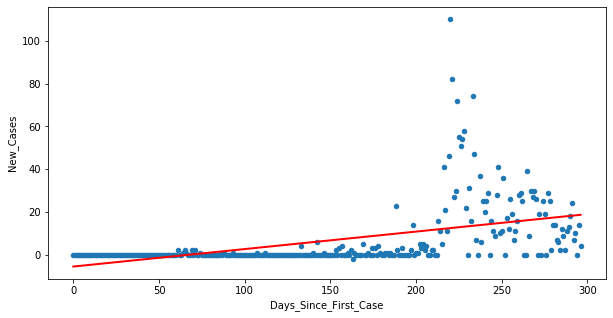

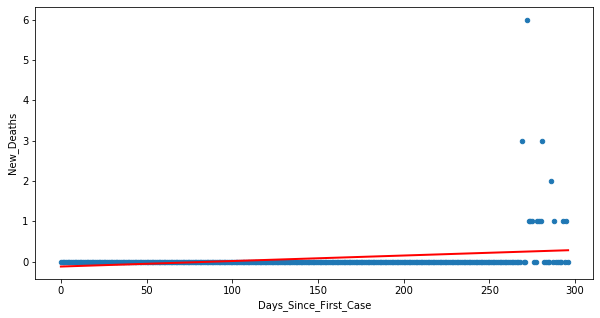

In [33]:
# Linear model for cases and deaths

linear_cases = smf.ols(formula='New_Cases ~ Days_Since_First_Case', data=Whitman_merged).fit()
linear_deaths = smf.ols(formula = 'New_Deaths ~ Days_Since_First_Case', data=Whitman_merged).fit()

# Predictions based on max and min values for Days_Since_First_Case

pred_cases_linear = linear_cases.predict(Whitman_merged["Days_Since_First_Case"])
pred_deaths_linear = linear_deaths.predict(Whitman_merged["Days_Since_First_Case"])

print(pred_cases_linear)
print(pred_deaths_linear)

# Plot data and linear regression model for New_Cases

Whitman_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Cases', figsize=(10, 5))
plt.plot(Whitman_merged["Days_Since_First_Case"], pred_cases_linear, c='red', linewidth=2)

# Plot data and linear regression model for New_Deaths

Whitman_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Deaths', figsize=(10, 5))
plt.plot(Whitman_merged["Days_Since_First_Case"], pred_deaths_linear, c='red', linewidth=2)

print(linear_cases.summary())
print(linear_deaths.summary())

# Calculate RMSE
RMSE_cases_linear=smfem.rmse(x1=Whitman_merged["New_Cases"], x2=pred_cases_linear)
RMSE_deaths_linear=smfem.rmse(x1=Whitman_merged["New_Deaths"], x2=pred_deaths_linear)
print("Linear Regression Model for New Cases RMSE: ", RMSE_cases_linear)
print("Linear Regression MOdel for New Deaths RMSE: ", RMSE_deaths_linear)


0     -1.126298
1     -1.067398
2     -1.007037
3     -0.945406
4     -0.882691
         ...   
292    4.069201
293    2.830088
294    1.543353
295    0.208033
296   -1.176845
Length: 297, dtype: float64
0      0.082490
1      0.073329
2      0.064627
3      0.056371
4      0.048549
         ...   
292    0.670313
293    0.681162
294    0.691932
295    0.702613
296    0.713199
Length: 297, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     36.52
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           5.47e-29
Time:                        21:10:11   Log-Likelihood:                -1142.8
No. Observations:                 297   AIC:                             2298.
Df Residuals:                     291  

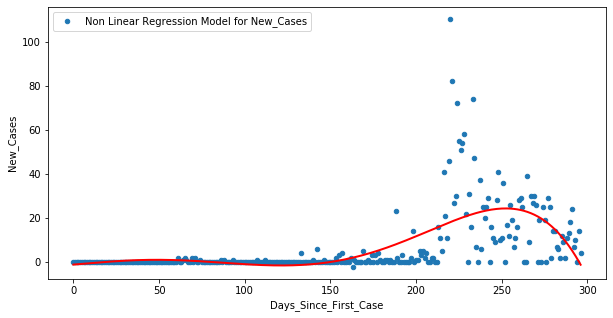

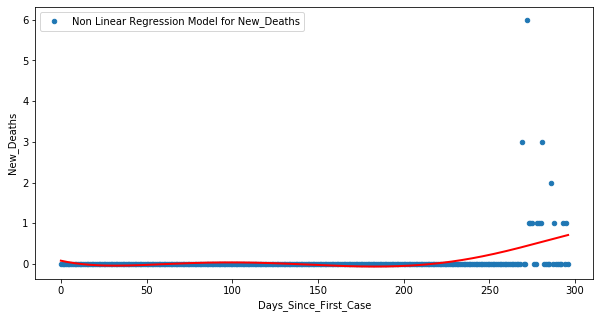

In [34]:
# Non-linear fitted models for cases and deaths

nonlinear_cases = smf.ols(formula="New_Cases ~ 1 + Days_Since_First_Case + I(Days_Since_First_Case ** 2.0) + I(Days_Since_First_Case ** 3.0) + I(Days_Since_First_Case ** 4.0) + I(Days_Since_First_Case ** 5.0)", data=Whitman_merged).fit()
nonlinear_deaths = smf.ols(formula="New_Deaths ~ 1 + Days_Since_First_Case + I(Days_Since_First_Case ** 2.0) + I(Days_Since_First_Case ** 3.0) + I(Days_Since_First_Case ** 4.0) + I(Days_Since_First_Case ** 5.0)", data=Whitman_merged).fit()


# Predictions for Days_Since_First_Case

pred_cases_nonlinear = nonlinear_cases.predict(Whitman_merged["Days_Since_First_Case"])
pred_deaths_nonlinear = nonlinear_deaths.predict(Whitman_merged["Days_Since_First_Case"])

print(pred_cases_nonlinear)
print(pred_deaths_nonlinear)

# Plot data and non-linear regression model for New_Cases

Whitman_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Cases', label="Non Linear Regression Model for New_Cases", figsize=(10, 5))
plt.plot(Whitman_merged["Days_Since_First_Case"], pred_cases_nonlinear, c='red', linewidth=2)

# Plot data and non-linear regression model for New_Deaths

Whitman_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Deaths', label="Non Linear Regression Model for New_Deaths", figsize=(10, 5))
plt.plot(Whitman_merged["Days_Since_First_Case"], pred_deaths_nonlinear, c='red', linewidth=2)

print(nonlinear_cases.summary())
print(nonlinear_deaths.summary())

# Calculate RMSE

RMSE_cases_nonlinear=smfem.rmse(x1=Whitman_merged["New_Cases"], x2=pred_cases_nonlinear)
RMSE_deaths_nonlinear=smfem.rmse(x1=Whitman_merged["New_Deaths"], x2=pred_deaths_nonlinear)
print("Non-Linear Regression Model for New Cases RMSE: ", RMSE_cases_nonlinear)
print("Non-Linear Regression Model for New Deaths RMSE: ", RMSE_deaths_nonlinear)

#### Grant County

In [35]:
Grant_pop_data=WA_pop_data[WA_pop_data['County Name'] == 'Grant County']
Grant_pop=Grant_pop_data['population'].sum()

Grant_confirmed_data=WA_confirmed_data[WA_confirmed_data['County Name']=='Grant County']
Grant_confirmed_data.drop(['County Name'], axis=1, inplace=True)
Grant_confirmed_daily = pd.DataFrame(Grant_confirmed_data[Grant_confirmed_data.columns[0:]].sum()).reset_index()
Grant_confirmed_daily.columns=["Date", "Confirmed Cases"]
Grant_confirmed_daily["Date"] = pd.to_datetime(Grant_confirmed_daily["Date"])
Grant_confirmed_daily["Week"] = Grant_confirmed_daily["Date"].dt.week



Grant_death_data=WA_death_data[WA_death_data['County Name']=='Grant County']
Grant_death_data.drop(['County Name'], axis=1, inplace=True)
Grant_death_daily = pd.DataFrame(Grant_death_data[Grant_death_data.columns[0:]].sum()).reset_index()
Grant_death_daily.columns=["Date", "Deaths"]
Grant_death_daily["Date"] = pd.to_datetime(Grant_death_daily["Date"])
Grant_death_daily["Week"] = Grant_death_daily["Date"].dt.week


Grant_merged=Grant_confirmed_daily.merge(Grant_death_daily)
Grant_merged=Grant_merged[["Date", "Week", "Confirmed Cases", "Deaths"]]
Grant_merged.head()

# Create Days_Since_First_Case column

Grant_merged.reset_index(inplace=True)
Grant_merged=Grant_merged.rename(columns= {'index': 'Days_Since_First_Case'})
Grant_merged.head()

# Calculate New_Cases and New_Deaths

Grant_merged["New_Cases"]=Grant_merged["Confirmed Cases"].diff()
Grant_merged["New_Deaths"]=Grant_merged["Deaths"].diff()
Grant_merged["New_Cases"].fillna(0.0, inplace=True)
Grant_merged["New_Deaths"].fillna(0.0, inplace=True)
Grant_merged

,Days_Since_First_Case,Date,Week,Confirmed Cases,Deaths,New_Cases,New_Deaths
0,0,2020-01-22,4,0,0,0.0,0.0
1,1,2020-01-23,4,0,0,0.0,0.0
2,2,2020-01-24,4,0,0,0.0,0.0
3,3,2020-01-25,4,0,0,0.0,0.0
4,4,2020-01-26,4,0,0,0.0,0.0
...,...,...,...,...,...,...,...
292,292,2020-11-09,46,3470,30,20.0,1.0
293,293,2020-11-10,46,3476,30,6.0,0.0
294,294,2020-11-11,46,3476,30,0.0,0.0
295,295,2020-11-12,46,3537,30,61.0,0.0


0      -2.232888
1      -2.135810
2      -2.038732
3      -1.941654
4      -1.844576
         ...    
292    26.113936
293    26.211014
294    26.308092
295    26.405170
296    26.502248
Length: 297, dtype: float64
0     -0.020066
1     -0.019248
2     -0.018430
3     -0.017612
4     -0.016794
         ...   
292    0.218814
293    0.219632
294    0.220450
295    0.221269
296    0.222087
Length: 297, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     76.17
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           1.96e-16
Time:                        21:10:12   Log-Likelihood:                -1251.9
No. Observations:                 297   AIC:                             2508.
Df Residuals:               

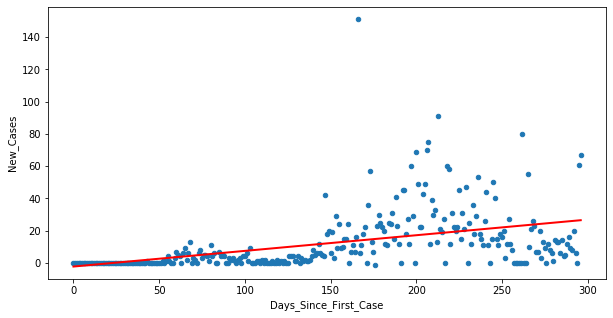

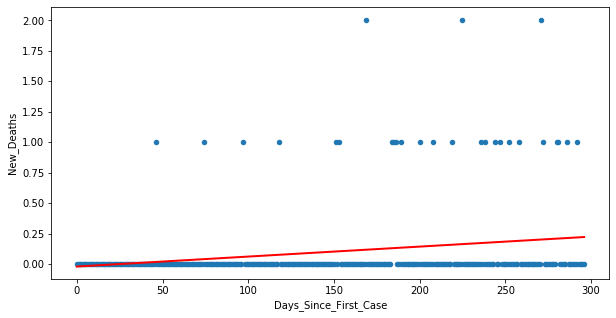

In [36]:
# Linear model for cases and deaths

linear_cases = smf.ols(formula='New_Cases ~ Days_Since_First_Case', data=Grant_merged).fit()
linear_deaths = smf.ols(formula = 'New_Deaths ~ Days_Since_First_Case', data=Grant_merged).fit()

# Predictions based on max and min values for Days_Since_First_Case

pred_cases_linear = linear_cases.predict(Grant_merged["Days_Since_First_Case"])
pred_deaths_linear = linear_deaths.predict(Grant_merged["Days_Since_First_Case"])

print(pred_cases_linear)
print(pred_deaths_linear)

# Plot data and linear regression model for New_Cases

Grant_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Cases', figsize=(10, 5))
plt.plot(Grant_merged["Days_Since_First_Case"], pred_cases_linear, c='red', linewidth=2)

# Plot data and linear regression model for New_Deaths

Grant_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Deaths', figsize=(10, 5))
plt.plot(Grant_merged["Days_Since_First_Case"], pred_deaths_linear, c='red', linewidth=2)

print(linear_cases.summary())
print(linear_deaths.summary())

# Calculate RMSE
RMSE_cases_linear=smfem.rmse(x1=Grant_merged["New_Cases"], x2=pred_cases_linear)
RMSE_deaths_linear=smfem.rmse(x1=Grant_merged["New_Deaths"], x2=pred_deaths_linear)
print("Linear Regression Model for New Cases RMSE: ", RMSE_cases_linear)
print("Linear Regression MOdel for New Deaths RMSE: ", RMSE_deaths_linear)


0      -9.278041
1      -8.171145
2      -7.122583
3      -6.130627
4      -5.193578
         ...    
292    16.959997
293    17.529139
294    18.147256
295    18.815980
296    19.536966
Length: 297, dtype: float64
0     -0.019515
1     -0.017158
2     -0.014888
3     -0.012701
4     -0.010595
         ...   
292    0.185333
293    0.184274
294    0.183186
295    0.182069
296    0.180923
Length: 297, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     32.61
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           2.25e-26
Time:                        21:10:13   Log-Likelihood:                -1219.9
No. Observations:                 297   AIC:                             2452.
Df Residuals:               

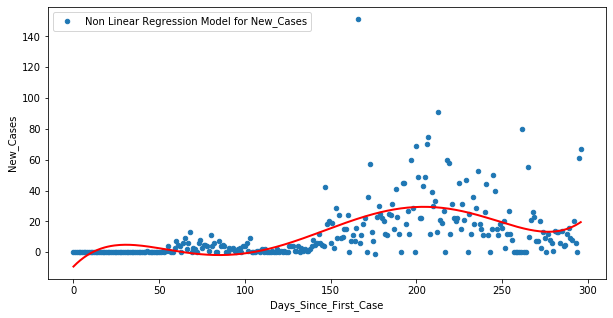

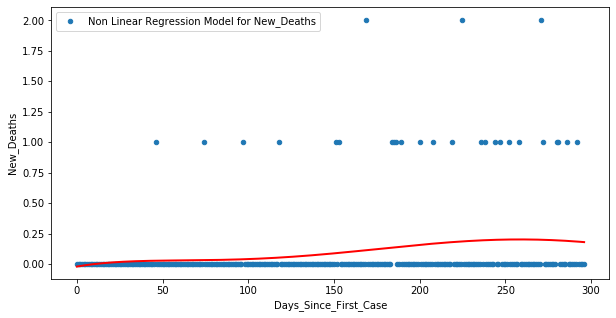

In [37]:
# Non-linear fitted models for cases and deaths

nonlinear_cases = smf.ols(formula="New_Cases ~ 1 + Days_Since_First_Case + I(Days_Since_First_Case ** 2.0) + I(Days_Since_First_Case ** 3.0) + I(Days_Since_First_Case ** 4.0) + I(Days_Since_First_Case ** 5.0)", data=Grant_merged).fit()
nonlinear_deaths = smf.ols(formula="New_Deaths ~ 1 + Days_Since_First_Case + I(Days_Since_First_Case ** 2.0) + I(Days_Since_First_Case ** 3.0) + I(Days_Since_First_Case ** 4.0) + I(Days_Since_First_Case ** 5.0)", data=Grant_merged).fit()


# Predictions for Days_Since_First_Case

pred_cases_nonlinear = nonlinear_cases.predict(Grant_merged["Days_Since_First_Case"])
pred_deaths_nonlinear = nonlinear_deaths.predict(Grant_merged["Days_Since_First_Case"])

print(pred_cases_nonlinear)
print(pred_deaths_nonlinear)

# Plot data and non-linear regression model for New_Cases

Grant_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Cases', label="Non Linear Regression Model for New_Cases", figsize=(10, 5))
plt.plot(Grant_merged["Days_Since_First_Case"], pred_cases_nonlinear, c='red', linewidth=2)

# Plot data and non-linear regression model for New_Deaths

Grant_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Deaths', label="Non Linear Regression Model for New_Deaths", figsize=(10, 5))
plt.plot(Grant_merged["Days_Since_First_Case"], pred_deaths_nonlinear, c='red', linewidth=2)

print(nonlinear_cases.summary())
print(nonlinear_deaths.summary())

# Calculate RMSE

RMSE_cases_nonlinear=smfem.rmse(x1=Grant_merged["New_Cases"], x2=pred_cases_nonlinear)
RMSE_deaths_nonlinear=smfem.rmse(x1=Grant_merged["New_Deaths"], x2=pred_deaths_nonlinear)
print("Non-Linear Regression Model for New Cases RMSE: ", RMSE_cases_nonlinear)
print("Non-Linear Regression Model for New Deaths RMSE: ", RMSE_deaths_nonlinear)

0      -9.278041
1      -8.171145
2      -7.122583
3      -6.130627
4      -5.193578
         ...    
292    16.959997
293    17.529139
294    18.147256
295    18.815980
296    19.536966
Length: 297, dtype: float64
0     -0.019515
1     -0.017158
2     -0.014888
3     -0.012701
4     -0.010595
         ...   
292    0.185333
293    0.184274
294    0.183186
295    0.182069
296    0.180923
Length: 297, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     32.61
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           2.25e-26
Time:                        21:10:14   Log-Likelihood:                -1219.9
No. Observations:                 297   AIC:                             2452.
Df Residuals:               

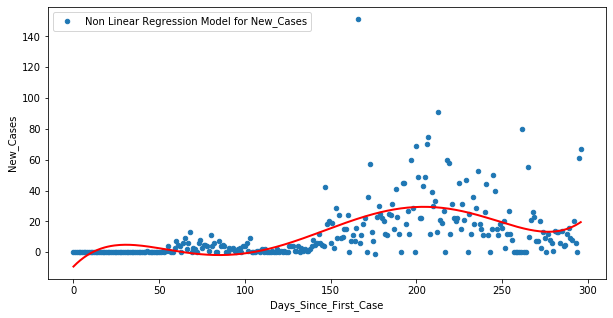

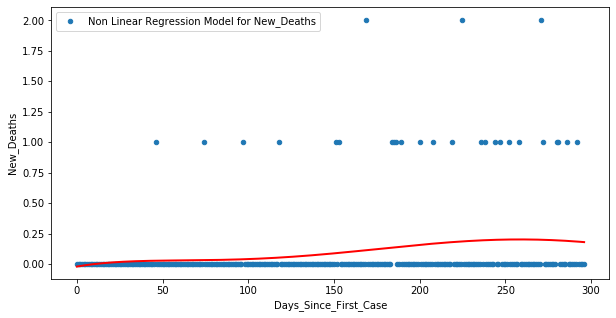

In [38]:
#### Grant County

Grant_pop_data=WA_pop_data[WA_pop_data['County Name'] == 'Grant County']
Grant_pop=Grant_pop_data['population'].sum()

Grant_confirmed_data=WA_confirmed_data[WA_confirmed_data['County Name']=='Grant County']
Grant_confirmed_data.drop(['County Name'], axis=1, inplace=True)
Grant_confirmed_daily = pd.DataFrame(Grant_confirmed_data[Grant_confirmed_data.columns[0:]].sum()).reset_index()
Grant_confirmed_daily.columns=["Date", "Confirmed Cases"]
Grant_confirmed_daily["Date"] = pd.to_datetime(Grant_confirmed_daily["Date"])
Grant_confirmed_daily["Week"] = Grant_confirmed_daily["Date"].dt.week



Grant_death_data=WA_death_data[WA_death_data['County Name']=='Grant County']
Grant_death_data.drop(['County Name'], axis=1, inplace=True)
Grant_death_daily = pd.DataFrame(Grant_death_data[Grant_death_data.columns[0:]].sum()).reset_index()
Grant_death_daily.columns=["Date", "Deaths"]
Grant_death_daily["Date"] = pd.to_datetime(Grant_death_daily["Date"])
Grant_death_daily["Week"] = Grant_death_daily["Date"].dt.week


Grant_merged=Grant_confirmed_daily.merge(Grant_death_daily)
Grant_merged=Grant_merged[["Date", "Week", "Confirmed Cases", "Deaths"]]
Grant_merged.head()

# Create Days_Since_First_Case column

Grant_merged.reset_index(inplace=True)
Grant_merged=Grant_merged.rename(columns= {'index': 'Days_Since_First_Case'})
Grant_merged.head()

# Calculate New_Cases and New_Deaths

Grant_merged["New_Cases"]=Grant_merged["Confirmed Cases"].diff()
Grant_merged["New_Deaths"]=Grant_merged["Deaths"].diff()
Grant_merged["New_Cases"].fillna(0.0, inplace=True)
Grant_merged["New_Deaths"].fillna(0.0, inplace=True)
Grant_merged

# Non-linear fitted models for cases and deaths

nonlinear_cases = smf.ols(formula="New_Cases ~ 1 + Days_Since_First_Case + I(Days_Since_First_Case ** 2.0) + I(Days_Since_First_Case ** 3.0) + I(Days_Since_First_Case ** 4.0) + I(Days_Since_First_Case ** 5.0)", data=Grant_merged).fit()
nonlinear_deaths = smf.ols(formula="New_Deaths ~ 1 + Days_Since_First_Case + I(Days_Since_First_Case ** 2.0) + I(Days_Since_First_Case ** 3.0) + I(Days_Since_First_Case ** 4.0) + I(Days_Since_First_Case ** 5.0)", data=Grant_merged).fit()


# Predictions for Days_Since_First_Case

pred_cases_nonlinear = nonlinear_cases.predict(Grant_merged["Days_Since_First_Case"])
pred_deaths_nonlinear = nonlinear_deaths.predict(Grant_merged["Days_Since_First_Case"])

print(pred_cases_nonlinear)
print(pred_deaths_nonlinear)

# Plot data and non-linear regression model for New_Cases

Grant_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Cases', label="Non Linear Regression Model for New_Cases", figsize=(10, 5))
plt.plot(Grant_merged["Days_Since_First_Case"], pred_cases_nonlinear, c='red', linewidth=2)

# Plot data and non-linear regression model for New_Deaths

Grant_merged.plot(kind='scatter', x='Days_Since_First_Case', y='New_Deaths', label="Non Linear Regression Model for New_Deaths", figsize=(10, 5))
plt.plot(Grant_merged["Days_Since_First_Case"], pred_deaths_nonlinear, c='red', linewidth=2)

print(nonlinear_cases.summary())
print(nonlinear_deaths.summary())

# Calculate RMSE

RMSE_cases_nonlinear=smfem.rmse(x1=Grant_merged["New_Cases"], x2=pred_cases_nonlinear)
RMSE_deaths_nonlinear=smfem.rmse(x1=Grant_merged["New_Deaths"], x2=pred_deaths_nonlinear)
print("Non-Linear Regression Model for New Cases RMSE: ", RMSE_cases_nonlinear)
print("Non-Linear Regression Model for New Deaths RMSE: ", RMSE_deaths_nonlinear)

#### Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.

In [39]:
# read in hospital data

hospital_data = pd.read_csv("..\data\Definitive_Healthcare_USA_Hospital_Beds.csv")
WA_hospital_data = hospital_data[hospital_data['HQ_STATE']== 'WA']
WA_hospital_data.head(1)


,X,Y,OBJECTID,HOSPITAL_NAME,HOSPITAL_TYPE,HQ_ADDRESS,HQ_ADDRESS1,HQ_CITY,HQ_STATE,HQ_ZIP_CODE,...,CNTY_FIPS,FIPS,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
3986,-119.155282,46.831164,3987,Othello Community Hospital,Critical Access Hospital,315 N 14th Ave,NaN,Othello,WA,99344,...,1.0,53001.0,49.0,16.0,3,3,0.0,0.161301,33,1.0


In [40]:
WA_hospital_data.drop(["X", "Y", "OBJECTID", "HOSPITAL_NAME", "HOSPITAL_TYPE", "HQ_ADDRESS", "HQ_ADDRESS1", "HQ_CITY", "HQ_STATE", "HQ_ZIP_CODE", "CNTY_FIPS", "FIPS", "COUNTY_NAME", "STATE_NAME", "STATE_FIPS"], axis=1, inplace=True)
WA_hospital_data.head(1)

,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
3986,49.0,16.0,3,3,0.0,0.161301,33,1.0


In [41]:
WA_hospital_data["Total_Beds"]=WA_hospital_data['NUM_LICENSED_BEDS'] + WA_hospital_data['NUM_STAFFED_BEDS'] + WA_hospital_data['NUM_ICU_BEDS'] + WA_hospital_data['ADULT_ICU_BEDS'] + WA_hospital_data['PEDI_ICU_BEDS']
WA_hospital_data.head()

C:\Users\sandm\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE,Total_Beds
3986,49.0,16.0,3,3,0.0,0.161301,33,1.0,71.0
3987,62.0,25.0,4,4,0.0,0.474849,37,2.0,95.0
3988,25.0,25.0,4,4,0.0,0.460055,0,2.0,58.0
3989,111.0,111.0,14,14,10.0,0.455856,0,6.0,260.0
3990,270.0,248.0,30,30,27.0,0.791471,22,15.0,605.0


In [42]:
WA_hospital_data["Total_Occupied_Beds"] = round((WA_hospital_data["BED_UTILIZATION"] * WA_hospital_data["Total_Beds"]), 0)
WA_hospital_data.head()

C:\Users\sandm\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE,Total_Beds,Total_Occupied_Beds
3986,49.0,16.0,3,3,0.0,0.161301,33,1.0,71.0,11.0
3987,62.0,25.0,4,4,0.0,0.474849,37,2.0,95.0,45.0
3988,25.0,25.0,4,4,0.0,0.460055,0,2.0,58.0,27.0
3989,111.0,111.0,14,14,10.0,0.455856,0,6.0,260.0,119.0
3990,270.0,248.0,30,30,27.0,0.791471,22,15.0,605.0,479.0


In [43]:
WA_hospital_data['Open_Beds'] = WA_hospital_data["Total_Beds"] - WA_hospital_data['Total_Occupied_Beds']
WA_hospital_data.head()

C:\Users\sandm\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE,Total_Beds,Total_Occupied_Beds,Open_Beds
3986,49.0,16.0,3,3,0.0,0.161301,33,1.0,71.0,11.0,60.0
3987,62.0,25.0,4,4,0.0,0.474849,37,2.0,95.0,45.0,50.0
3988,25.0,25.0,4,4,0.0,0.460055,0,2.0,58.0,27.0,31.0
3989,111.0,111.0,14,14,10.0,0.455856,0,6.0,260.0,119.0,141.0
3990,270.0,248.0,30,30,27.0,0.791471,22,15.0,605.0,479.0,126.0


In [44]:
Total_Open_Beds=WA_hospital_data['Open_Beds'].sum()
Total_Beds=WA_hospital_data['Total_Beds'].sum()
print("Total Beds: ", Total_Beds)
print("Total Remaining Open Beds: ", Total_Open_Beds)

Total Beds:  32200.0
Total Remaining Open Beds:  10713.0


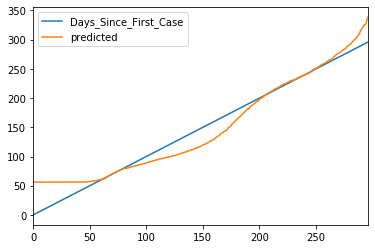

In [45]:

coef = np.polyfit(WA_merged['Confirmed Cases'], WA_merged['Days_Since_First_Case'], 1)

WA_merged['predicted'] = pd.Series(np.polyval(coef, WA_merged['Confirmed Cases']))
WA_merged[['Days_Since_First_Case', 'predicted']].plot()

In [46]:
x=Total_Open_Beds
print('Predicted Usage of All {:.0f} Remaining Beds: {:.0f} days'.format(x, np.polyval(coef, x)))


Predicted Usage of All 10713 Remaining Beds: 80 days


#### The predicted point of no return appears to be 80 days. At that time, all available beds will be full.

#### Utilize decision tree, random forest, and ARIMA (https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) based models to compare and contrast the performance of each. X-variable is the previous weeks data, Y-variable is current week data. So you are predicting one week in advance. Calculate RMSE error. This is just based on number of cases.

In [125]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn import tree

In [75]:
WA_merged.tail()

,Days_Since_First_Case,Date,Week,Confirmed Cases,Deaths,New_Cases,New_Deaths,predicted
292,292,2020-11-09,46,118570,2459,1239.0,22.0,322.866728
293,293,2020-11-10,46,120011,2482,1441.0,23.0,326.108027
294,294,2020-11-11,46,120011,2482,0.0,0.0,326.108027
295,295,2020-11-12,46,123356,2513,3345.0,31.0,333.632071
296,296,2020-11-13,46,125498,2519,2142.0,6.0,338.450158


In [90]:
WA_merged.head()

,Days_Since_First_Case,Date,Week,Confirmed Cases,Deaths,New_Cases,New_Deaths,predicted
0,0,2020-01-22,4,1,0,0.0,0.0,-21232.316046
1,1,2020-01-23,4,1,0,0.0,0.0,-20812.985082
2,2,2020-01-24,4,1,0,0.0,0.0,-20393.654118
3,3,2020-01-25,4,1,0,0.0,0.0,-19974.323154
4,4,2020-01-26,4,1,0,0.0,0.0,-19554.992189


In [127]:


x = WA_merged.drop(['Confirmed Cases', 'Date', 'predicted'],  axis=1)
y = WA_merged['Confirmed Cases']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


regressor = DecisionTreeRegressor()
regressor.fit(x_train, y_train)

y_pred = regressor.predict(x_test)

In [129]:
WA_df = pd.DataFrame({'Actual': y_test, 'Predicted' : y_pred})
WA_df.head()

,Actual,Predicted
111,17326,17509.0
150,28220,27599.0
12,1,1.0
216,71700,71369.0
139,24353,24039.0


In [102]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 492.93333333333334
Mean Squared Error: 433432.7
Root Mean Squared Error: 658.3560586794961
